# Python Visualizations for Power Bi Dashboard

In [0]:
# Establishing a mount point
clientSecret = dbutils.secrets.get(scope = 'sfb_blob', key = 'bowser')
clientid = dbutils.secrets.get(scope = 'sfb_blob', key = 'yoshi') 

storageAccount = "gen10datafund2111"
storageContainer = "superfinancebros"
mount_point = "/mnt/superfinancebros/capstone"

# Configuration for mount point
configs = {"fs.azure.account.auth.type": "OAuth",
       "fs.azure.account.oauth.provider.type": "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
       "fs.azure.account.oauth2.client.id": clientid,
       "fs.azure.account.oauth2.client.secret": clientSecret,
       "fs.azure.account.oauth2.client.endpoint": "https://login.microsoftonline.com/d46b54b2-a652-420b-aa5a-2ef7f8fc706e/oauth2/token",
       "fs.azure.createRemoteFileSystemDuringInitialization": "true"}

try: 
    dbutils.fs.unmount(mount_point)
except:
    pass

dbutils.fs.mount(
source = "abfss://"+storageContainer+"@"+storageAccount+".dfs.core.windows.net/",
mount_point = mount_point,
extra_configs = configs)

/mnt/superfinancebros/capstone has been unmounted.
Out[120]: True

## Pair Grid of KDE plots and scatter plots

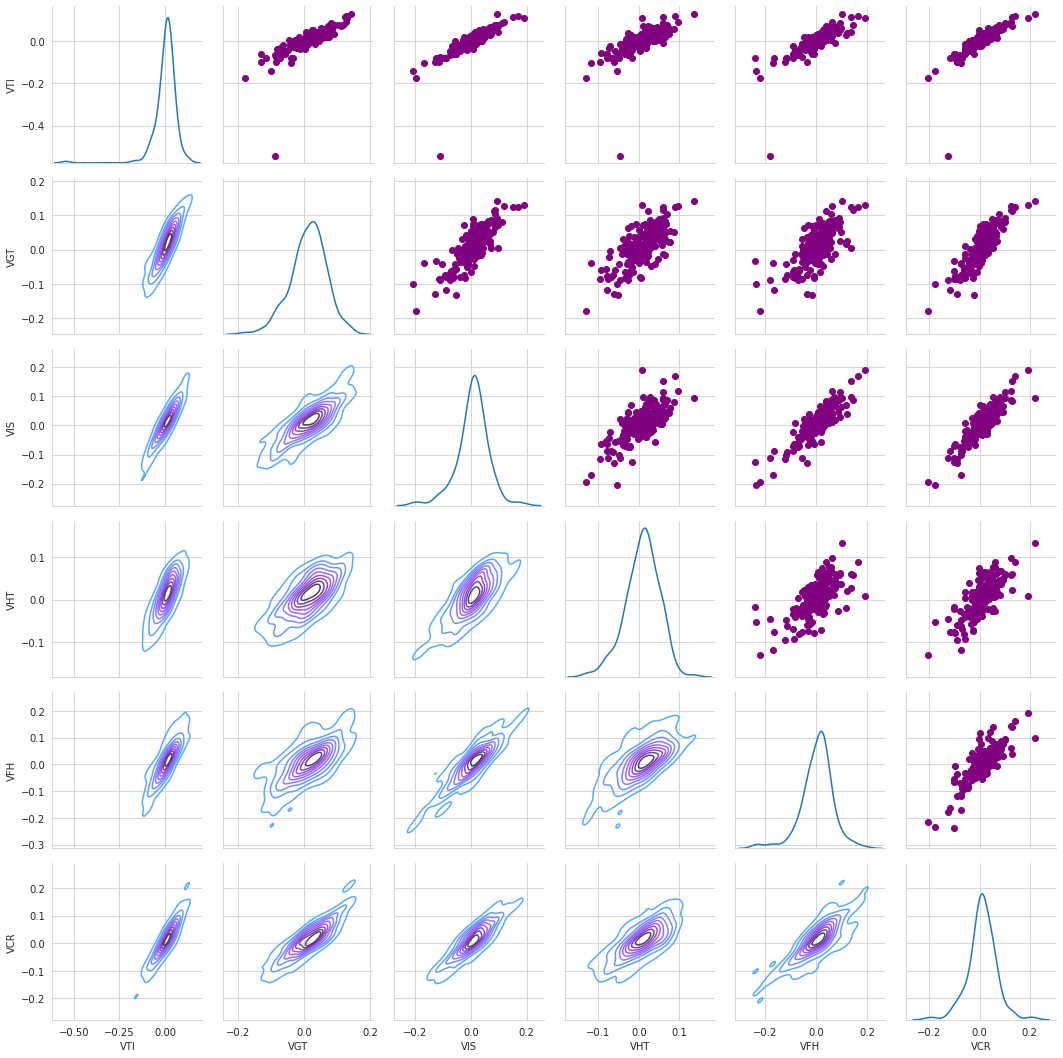

In [0]:
# Importing a file from our blob containter to use for creating the visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style(style='whitegrid')

monthly_df = pd.read_json(f'/dbfs{mount_point}/Cleaned_Dataframes/monthly_data.json')

stock_prices = monthly_df.drop(columns=['Real Gross Domestic Product',
       '10-Year Treasury Constant Maturity Rate',
       'Consumer Price Index for all Urban Consumers',
       'Inflation Expectations', 'Consumer Sentiment & Consumer Confidence',
       'Advance Retail Sales: Retail Trade', 'Unemployment Rate','date'])

stock_prices.drop_duplicates(inplace=True)

pct_changes = stock_prices.pct_change()

pct_changes.drop(0,inplace=True)
closing_fig = sns.PairGrid(pct_changes)

closing_fig.map_upper(plt.scatter,color='purple')

closing_fig.map_lower(sns.kdeplot,cmap='cool_d')

closing_fig.map_diag(sns.kdeplot)

plt.show(closing_fig)

In [0]:
# Establishing a connection to our SQL database to read in the monthlyData table to a Pandas DataFrame
server = 'tcp:gen10-data-fundamentals-21-11-sql-server.database.windows.net'
database = 'Super-Finance-Bros'
username = dbutils.secrets.get(scope = 'sfb_blob', key = 'birdo')
password = dbutils.secrets.get(scope = 'sfb_blob', key = 'donkeykong')
jdbcUrl = f"jdbc:sqlserver://gen10-data-fundamentals-21-11-sql-server.database.windows.net:1433;database=Super-Financial-Bros"
connectionProperties = {
   "user" : username,
   "password" : password,
   "driver" : "com.microsoft.sqlserver.jdbc.SQLServerDriver"
   }

#Trying with SQL table for monthly_data
sql_df = spark.read.jdbc(url=jdbcUrl, table='monthlyData',properties = connectionProperties)

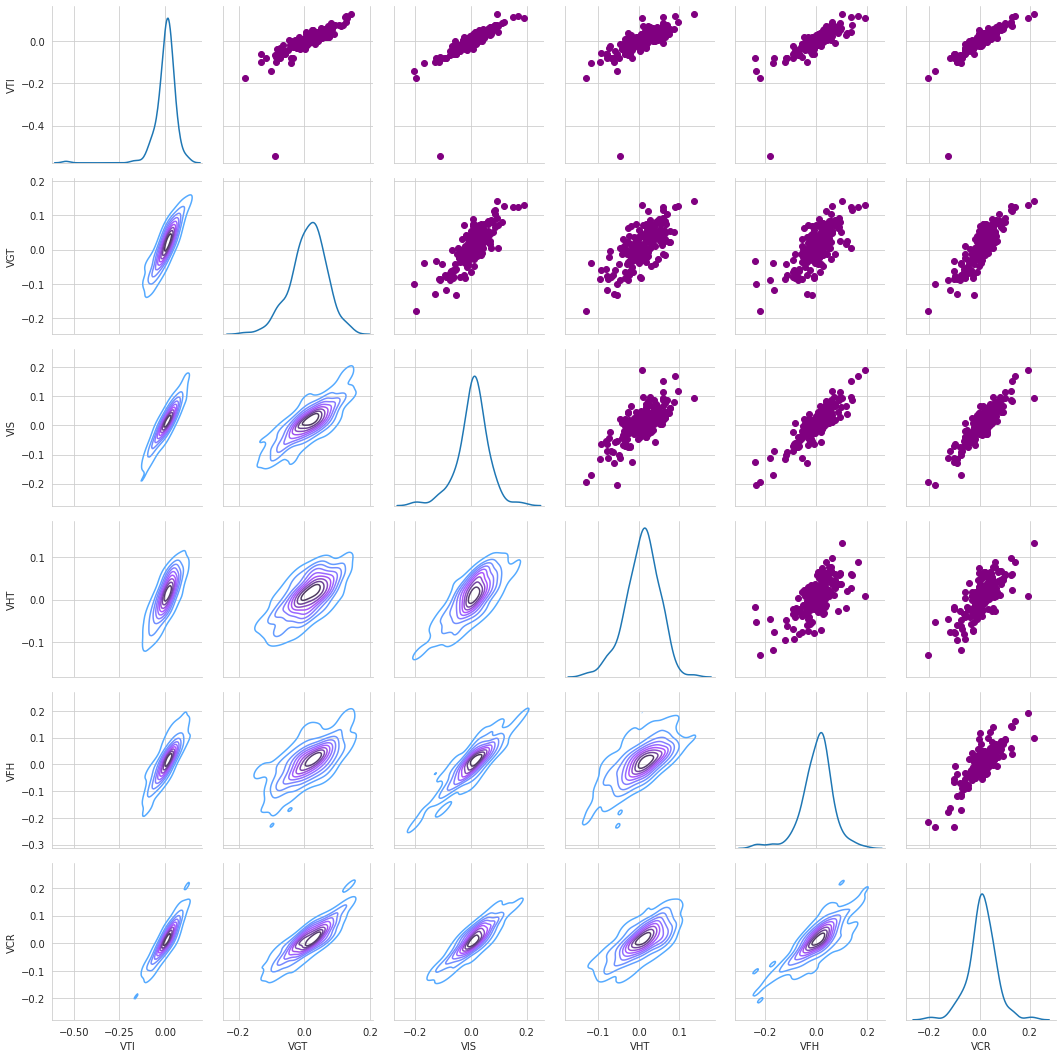

In [0]:
sql_to_pd_df = sql_df.toPandas()
sql_to_pd_df.sort_values(by='date',axis=0,inplace=True)

# Transforming the SQL table for the Pair Grid visualization
stock_prices = sql_to_pd_df.drop(columns=['Real Gross Domestic Product',
       '10-Year Treasury Constant Maturity Rate',
       'Consumer Price Index for all Urban Consumers',
       'Inflation Expectations', 'Consumer Sentiment & Consumer Confidence',
       'Advance Retail Sales: Retail Trade', 'Unemployment Rate','date'])

stock_prices.drop_duplicates(inplace=True)

pct_changes = stock_prices.pct_change()

pct_changes.drop(0,inplace=True)
closing_fig = sns.PairGrid(pct_changes)

closing_fig.map_upper(plt.scatter,color='purple')

closing_fig.map_lower(sns.kdeplot,cmap='cool_d')

closing_fig.map_diag(sns.kdeplot)

plt.show(closing_fig)

## Scatter Plot of Risk vs. Expected Returns for all ETF index funds

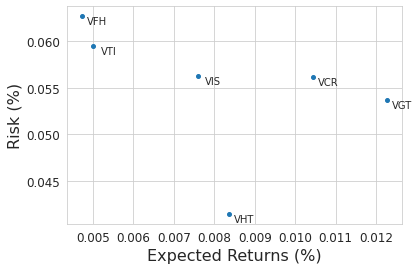

In [0]:
area = np.pi * 5
plt.scatter(x=pct_changes.mean(),y=pct_changes.std(),s=area)

# Changed font sizes from the default for readability in the dashboard
plt.xlabel('Expected Returns (%)',fontdict={'fontsize':16})
plt.xticks(fontsize=12)

plt.ylabel('Risk (%)',fontdict={'fontsize':16})
plt.yticks(fontsize=12)

for label, x, y in zip(pct_changes.columns, pct_changes.mean(), pct_changes.std()):
    plt.annotate(label,xy = (x,y), xytext = (15,-10),
                textcoords = 'offset points', ha='center',va='bottom')

# Title created in the dashboard
plt.show()

## Correlation Matrix

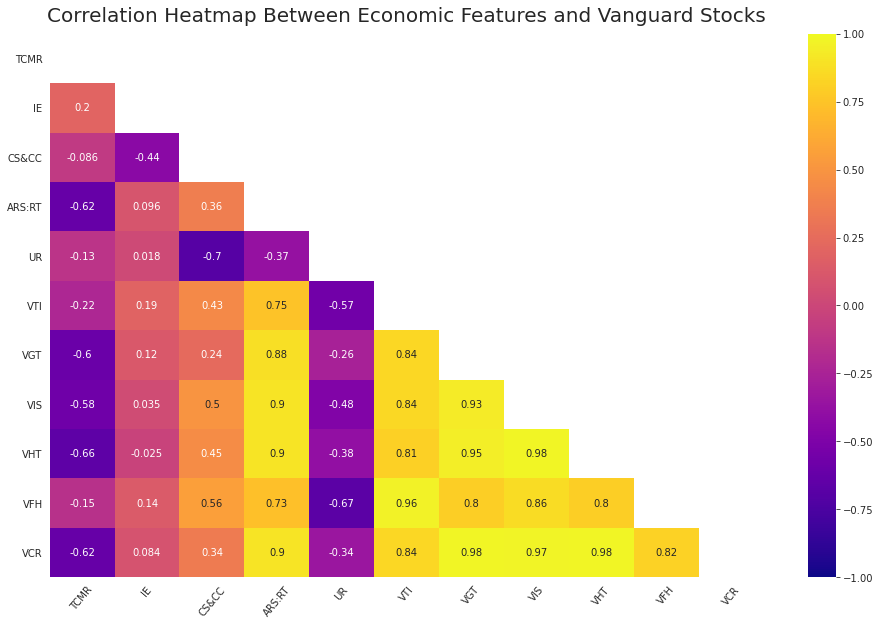

In [0]:
import seaborn as sns
import numpy as np
from matplotlib.text import Text
import matplotlib.pyplot as plt

corr_df = monthly_df.drop(columns=['Real Gross Domestic Product',
       'Consumer Price Index for all Urban Consumers','date'])

# Creates a mask for the upper right triangle of the Correlation Heatmap
mask = np.zeros_like(corr_df.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# vmin and vmax apply lower and upper bound for the correlation values. The cmap parameter sets
# the color map for the visualization. 
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(corr_df.corr(), vmin=-1, vmax=1, mask=mask, annot=True, cmap='plasma')
heatmap.set_title('Correlation Heatmap Between Economic Features and Vanguard Stocks', fontdict={'fontsize':20}, pad=12)

# Adjusts the x-axis and y-axis tick labels

xlabels = [Text(0, 0, 'TCMR'), # 10-Year Treasury Constant Maturity Rate
  Text(0.5, 0, 'IE'), # Inflation Expectations
  Text(2, 0, 'CS&CC'), # Consumer Sentiment & Consumer Confidence
  Text(2.5, 0, 'ARS:RT'), # Advance Retail Sales: Retail Trade
  Text(3.5, 0, 'UR'), # Unemployment Rate
  Text(5.5, 0, 'VTI'),
  Text(6.5, 0, 'VGT'),
  Text(7.5, 0, 'VIS'),
  Text(8.5, 0, 'VHT'),
  Text(9.5, 0, 'VFH'),
  Text(10.5, 0, 'VCR')]

ylabels = [Text(0, 0.5, 'TCMR'),
  Text(0, 1.5, 'IE'),
  Text(0, 2.5, 'CS&CC'),
  Text(0, 3.5, 'ARS:RT'),
  Text(0, 4.5, 'UR'),
  Text(0, 5.5, 'VTI'),
  Text(0, 6.5, 'VGT'),
  Text(0, 7.5, 'VIS'),
  Text(0, 8.5, 'VHT'),
  Text(0, 9.5, 'VFH'),
  Text(0, 10.5, 'VCR')]
sns.utils.plt.xticks(ticks=np.array([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]),labels=xlabels,rotation=50)
sns.utils.plt.yticks(ticks=np.array([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]),labels=ylabels)

plt.show()